# Data Analysis for GaitWay Priliminary Data Collection Phase

In this notebook, we conduct exploratory data analysis to investigate various perspectives we can take to look at the data collected during the priliminary data collection using the GaitWay setup.

In [1]:
import numpy as np
from scipy import interpolate
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import py_wholebodymovement as wbm

First, we load the data (ported and preprocessed from the MySQL database table `gaitway_db.captureddata`) from a zip file into the pandas dataframe `captureddata_df`'

In [2]:
captureddata_df = pd.read_csv('../data/captureddata_1.zip', compression='infer')

user_ids    = captureddata_df.UserID.unique()
movements   = captureddata_df.MovementName.unique()
joint_names = wbm.predefined_schemas._JOINT_NAMES_3

The loaded dataset contains {{ captureddata_df.shape[0] }} rows each corresponding to a frame. There are {{ len(user_ids) }} participants (also referred to as users) in this dataset performing the following movements during various sessions:

<b>{{ '<br />'.join(sorted(list(movements))) }}</b>

In this notebook, we will only analyze the data for participants `PFLXXX` (dropping some of them too; see below).

The dataset has {{ captureddata_df.shape[1] }} columns, consisting of participant ID, session number, movement name, time stamp, and $(x,y,z)$ coordinates of the {{ len(joint_names) }} points of interest (POIs) on the participants' bodies at each frame performing the moves:

<b>{{ "<br />".join(joint_names) }}</b>

Here are the first few rows of the dataset:

{{ display(captureddata_df.head()) }}

Here is a sample frame projected on the 2D $xy$ plane:

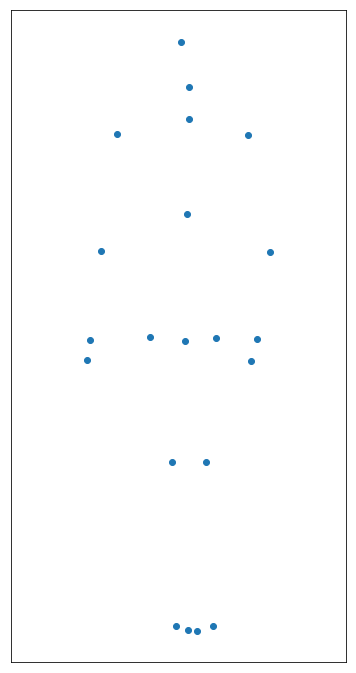

In [3]:
user_id        = 'PFL007'
session_number = 1
movement_name  = 'Idle'
frame_no       = 200

fig = plt.figure(figsize=(6,12))
row = captureddata_df[(captureddata_df.UserID == user_id) & 
                      (captureddata_df.SessionNumber == session_number) &
                      (captureddata_df.MovementName == movement_name)
                     ].iloc[frame_no,:]
xx = row[[cnm for cnm in captureddata_df.columns if '_x' in cnm]]
yy = row[[cnm for cnm in captureddata_df.columns if '_y' in cnm]]
plt.scatter(xx, yy,)
plt.xlim(min(xx)-.1, max(xx)+.1)
plt.ylim(min(yy)-.1, max(yy)+.1)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.axis('equal')
plt.show()

Next, we load the participants' demographic data:

In [4]:
participant_demographics = pd.read_csv("../data/BOT_dataset_latest_DH_20200428.csv", index_col='Participant_ID')
participant_demographics

,AGE,GENDER,HEIGHT,WEIGHT,BOT_grossraw_pre,BOT_totalraw_pre,BOT_grossraw_post,BOT_totalraw_post,Flanker_rawpre,Flanker_rawpost,...,DSM_hyper,DSM_cond,DSM_opp,Conners_Global_interp,Conners_inattent_interp,Conners_hyperact_interp,Conners_learn_prob_interp,Conners_exec_prob_interp,Conners_defiance_interp,Conners_peer_rel_interp
Participant_ID,,,,,,,,,,,,,,,,,,,,,
PFL001,13,1,177.0,64.2,42,69,45,71,20.0,19,...,23,1,3,5,5,5,3,5,3,5
PFL002,14,1,156.5,51.9,50,75,50,76,NaN,19,...,22,1,9,5,2,5,2,2,2,5
PFL003,17,1,165.0,73.7,43,70,43,68,19.0,20,...,6,1,6,4,2,4,2,2,2,3
PFL004,17,1,191.0,95.6,43,64,40,66,20.0,20,...,9,2,11,5,5,5,5,4,2,5
PFL005,14,1,151.0,35.2,45,65,40,67,20.0,20,...,1,1,1,2,4,4,5,2,2,5
PFL006,10,1,72.8,164.5,29,55,35,61,20.0,20,...,24,3,10,5,5,5,4,4,5,5
PFL007,16,1,153.0,49.5,42,69,47,73,20.0,20,...,0,0,0,2,2,2,2,2,2,4
PFL008,17,2,179.0,89.0,46,72,47,73,20.0,20,...,14,4,6,4,3,5,3,2,4,5
PFL010,11,1,175.0,67.0,47,74,46,73,20.0,20,...,8,0,1,2,5,3,5,5,2,2


We note that the participants are not gender balanced and should consider this in all of our analysis and possible conclusions.

## Breaking Down the Sessions to Individual Moves

Each session consists of a participant performing a sequence of moves and in this analysis, we wish to look at the data at the single _move_ level; that is, we want to look at various repetitions of a movement (e.g. jumping jacks) during a session separately. The following scrips creates a copy `captureddata_df_augmented` of the original dataset `captureddata_df` and change the movement names to unique move names of the format `<MOVE>@<FRAME>` where `MOVE` is one of the {{ len(movements) }} possible movements and `FRAME` is the ending frame of the corresponding move. For now we focus on the first few sessions only, determined by the value of `max_sessions` variable.

In [ ]:
%%time

max_sessions   = 6

unique_user_ids        = [gg for gg in captureddata_df.UserID.unique() if 'PFL' in gg]
unique_user_ids        = sorted(unique_user_ids)
unique_movement_names  = captureddata_df.MovementName.unique()
unique_session_numbers = captureddata_df.SessionNumber.unique()

captureddata_df_augmented = pd.DataFrame(columns=captureddata_df.columns)

for user_id_idx in range(len(unique_user_ids)):
    user_id = unique_user_ids[user_id_idx]
    print("User %s"%user_id)
    
    user_movement_session_numbers = sorted(captureddata_df[(captureddata_df.UserID==user_id) #& 
                                                   ].SessionNumber.unique())[:max_sessions]

    user_movement_session_numbers.sort()
    for session_number_inx in range(len(user_movement_session_numbers)):
        session_number = user_movement_session_numbers[session_number_inx]
        print("\tSessions %d"%session_number)
        
        session_data = captureddata_df[(captureddata_df.UserID == user_id) & 
                              (captureddata_df.SessionNumber == session_number) #&
                             ]
        if session_data.shape[0] == 0:
            continue

        captureddata_df_augmented = pd.concat([captureddata_df_augmented, session_data], axis=0)
        
        latest_movement_inx       = np.inf
        latest_movement_start_inx = session_data.index[0]
        latest_movement           = session_data.loc[latest_movement_start_inx, :].MovementName
        
        has_data = True
        
        while has_data:
            session_data_slice            = session_data.loc[latest_movement_start_inx:, :]
            
            latest_movement_start_inx     = session_data_slice.MovementName.ne(latest_movement).idxmax()
            
            if latest_movement_start_inx == session_data_slice.index[0]:
                has_data = False
                latest_movement_start_inx = session_data_slice.index[-1]

            captureddata_df_augmented.loc[session_data_slice.index[0]:latest_movement_start_inx, 'MovementName'
                                          ] = latest_movement+'@%d'%latest_movement_start_inx

            latest_movement               = session_data.loc[latest_movement_start_inx, :].MovementName

            print("\t\tMove %s at %d"%(latest_movement, latest_movement_start_inx))

To see a sample of the moves and their length (in frames), we run the following script:

In [6]:
%%time

coordinate_columns = [col_prefix+coord for col_prefix in joint_names for coord in ['_x', '_y', '_z']]
counts_pivot_table_aug = captureddata_df_augmented.groupby(['UserID', 'SessionNumber', 'MovementName'], as_index=False).size().to_frame('count').reset_index()
counts_pivot_table_aug.head(20)

,UserID,SessionNumber,MovementName,count
0,PFL001,1,Idle@1549440,2940
1,PFL001,1,Idle@1550220,480
2,PFL001,1,Idle@1550460,60
3,PFL001,1,Idle@1551120,120
4,PFL001,1,Idle@1551420,240
5,PFL001,1,Idle@1552020,60
6,PFL001,1,Idle@1552440,360
7,PFL001,1,Idle@1552920,420
8,PFL001,1,Idle@1553460,60
9,PFL001,1,Idle@1554180,360


And here's a histogram of the non-`Idle` move lengths:

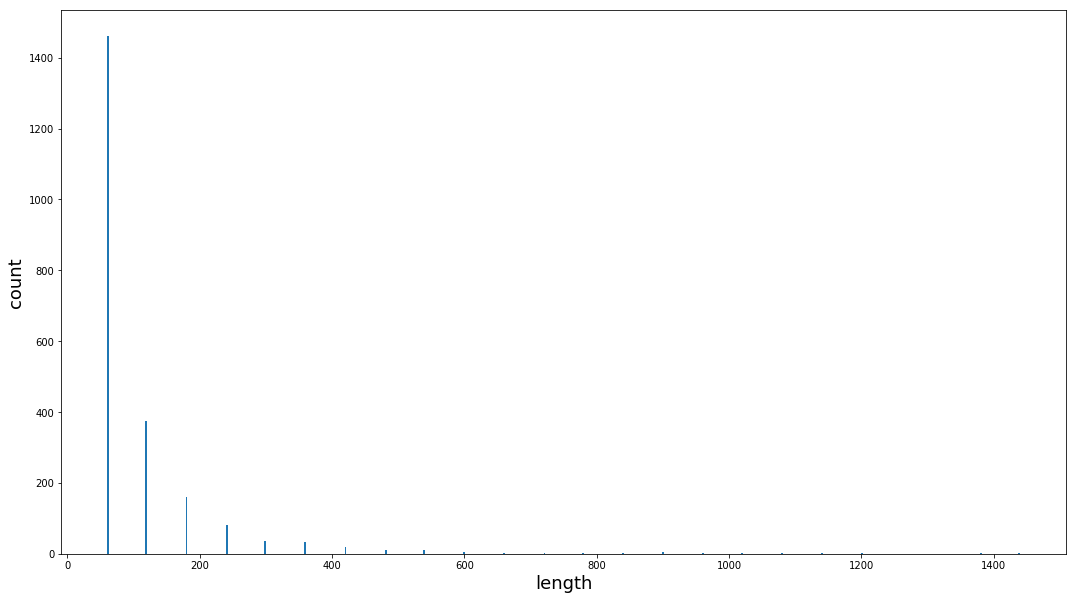

In [7]:
allcnts = counts_pivot_table_aug[(~counts_pivot_table_aug.MovementName.str.contains('Idle')) &
                                 (counts_pivot_table_aug.SessionNumber < 6)
                                ]['count'].values
plt.figure(figsize=(18,10))
plt.hist(allcnts, bins=500)
plt.xlabel('length', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.show()

## Denoising the Moves

Investigating the individual moves signals (see the blue plot below) we see that there are some high-frequency (HF) components present in the captured data that are physically unrealistic. These are artifacts of the data collection devices and procesdures which are not plausible in the context of human movement and need to be removed from the data. To this end, we use wavelet transforms through calling the `denoise_data` function to remove the HF artifacts of the data. Here is an example of the original signal (blue) and the denoised version (orange):

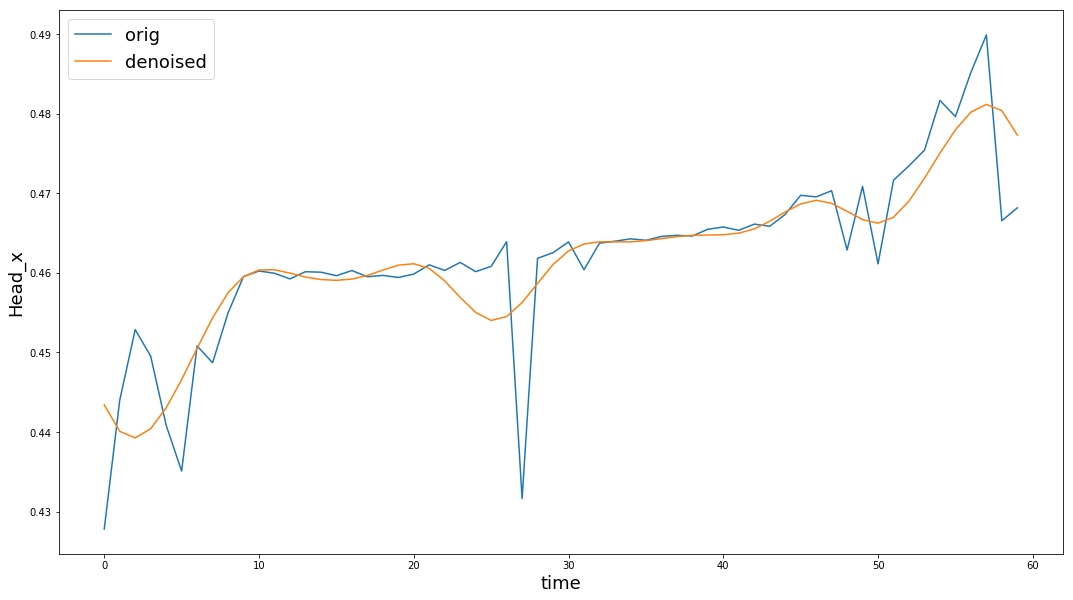

In [8]:
yy_orig = captureddata_df_augmented[captureddata_df_augmented.MovementName == 'JumpRight@2333400'].Head_x.values
yy = wbm.denoise_data(yy_orig, haarlevel=2, shrinking_factor=1)

plt.figure(figsize=(18,10))
plt.plot(yy_orig, label='orig')
plt.plot(yy, label='denoised')
plt.xlabel('time', fontsize=18)
plt.ylabel('Head_x', fontsize=18)
plt.legend(fontsize=18)
plt.show()

## Computing the Synchrony Measures of Articulated Figure Angles for Various Moves

We now use the data created above to analyze various summary statistics of moves and how they correlate with various demographics information. To do so, we go through the following steps:

1. For each move, we first use the $(x,y,z)$ coordinates of POIs to calculated various articulated figure angles for each frame. We do this by calling the function `calculate_3d_articulated_figure_angles` and specify the angles using the dictionary `_ARTICULATED_FIGURE_ANGLES_3`: <br/><br/>
<b> {{ print(str(wbm.predefined_schemas.\_ARTICULATED_FIGURE_ANGLES_3).replace("),", "),<br />").replace('"', '')) }} </b>
<br/><br/> Each entry in this dictionary is of the form `<angle_name>:(<T>,<U>,<S>,<WD>,<POS>)` where `angle_name` is the given name of the angle, and `T`, `U` and `S` are the names of the POIs which specify this angle as $\angle UTS$ (`<WD>` and `<POS>` are relvant only for 2D articulated figures; see documentation for details).

2. Next, we pick two of the angles `angle1` and `angle2` from the above articulated figure angles, denoise them using the procedure described before, and calculated various synchrony measures for them. Specifically, we calculate MARP, CRPSD [Meyns et. al.](https://doi.org/10.1016/j.ridd.2012.03.020) and PLV [Wang et. al.](https://doi.org/10.1109/IEMBS.2006.259673) and save them along with some of the demographics data in `sync_measures` table. We also calculate the sway variance as the variance of `tkf_theta`.

In [24]:
%%time

unique_user_ids        = [gg for gg in captureddata_df.UserID.unique() if 'PFL' in gg]
unique_user_ids        = sorted(unique_user_ids)
unique_movement_names  = captureddata_df.MovementName.unique()
unique_session_numbers = captureddata_df.SessionNumber.unique()

bar_colors = {
    'Normal': 'g',
    'Moderate': 'b',
    'Severe': 'r',
}

movement_name  = 'Walk'
max_sessions   = 6
angle1          = 'rshldr_theta'
angle2          = 'lhip_theta'

nrows, ncols = int(len(unique_user_ids)**.5)+1, int(len(unique_user_ids)**.5)
jj = 1

shrinking_factor = 1
sync_measures = pd.DataFrame(columns=['ParticipantID', 'BOT_totalraw_pre', 'BOT_grossraw_pre', 'AGE', 'HEIGHT', 'WEIGHT', 'MARP', 'CRPSD', 'PLV', 'sway_angle_var'])

miny, maxy = np.inf, -np.inf
for user_id_idx in range(len(unique_user_ids)):
    user_id = unique_user_ids[user_id_idx]
    if user_id not in participant_demographics.index:
        continue
    
    user_movement_first_session_number = sorted(captureddata_df[(captureddata_df.UserID==user_id) & 
                                                         (captureddata_df_augmented.MovementName.str.contains(movement_name))
                                                        ].SessionNumber.unique())[0]

    user_movement_session_trials = sorted(captureddata_df_augmented[(captureddata_df_augmented.UserID==user_id) &
                                                                    (captureddata_df_augmented.SessionNumber==user_movement_first_session_number) &
                                                                    (captureddata_df_augmented.MovementName.str.contains(movement_name))
                                                                   ].MovementName.unique())
    
    for trial_inx in range(len(user_movement_session_trials)):
        trial = user_movement_session_trials[trial_inx]
        
        session_data = captureddata_df_augmented[captureddata_df_augmented.MovementName == trial]
        if session_data.shape[0] == 0:
            continue
#         session_af_data = wbm.calculate_2d_articulated_figure_angles(session_data, 
#                                                                      angles=wbm.predefined_schemas._ARTICULATED_FIGURE_ANGLES_3,
#                                                                      x_suffix='_x', y_suffix='_y',
#                                                                     ).set_index(session_data.index)
        session_af_data = wbm.calculate_3d_articulated_figure_angles(wbm.extend_3d_articulated_figure(
                    session_data, 
                    dims=wbm.predefined_schemas._EXTENDED_JOINT_NAMES_3, 
                    copy=True, 
                    x_suffix='_x', 
                    y_suffix='_y', 
                    z_suffix='_z'),
             angles=wbm.predefined_schemas._ARTICULATED_FIGURE_ANGLES_3,
             x_suffix='_x', y_suffix='_y', z_suffix='_z',
            ).set_index(session_data.index)

        session_data = pd.concat([session_data, session_af_data], axis=1).ffill(axis='rows')
        haarlevel = 2
        denoised_session_data = pd.DataFrame(columns=[angle1, angle2])
        for angle in [angle1, angle2]:
            denoised_session_data.loc[:, angle] = wbm.denoise_data(session_data[angle].values, haarlevel=haarlevel, shrinking_factor=shrinking_factor)
        _, marp, _, crpsd  = wbm.calculate_phase_angle_measures(denoised_session_data, (angle1, angle2))
        _, plv, _, _, _, _ = wbm.calculate_phase_locking_value(denoised_session_data, (angle1, angle2))
        denoised_sway_angle_data = wbm.denoise_data(session_data['tkf_theta'].values, haarlevel=haarlevel, shrinking_factor=shrinking_factor)
        sway_angle_var     = np.var(denoised_sway_angle_data)
        
        sync_measures.loc[sync_measures.shape[0]] = [user_id,
                                                     1.*participant_demographics.loc[user_id, 'BOT_totalraw_pre'], 
                                                     1.*participant_demographics.loc[user_id, 'BOT_grossraw_pre'], 
                                                     1.*participant_demographics.loc[user_id, 'AGE'], 
                                                     1.*participant_demographics.loc[user_id, 'HEIGHT'], 
                                                     1.*participant_demographics.loc[user_id, 'WEIGHT'],
                                                     marp, 
                                                     crpsd, 
                                                     plv, 
                                                     sway_angle_var, 
                                                    ]
sync_measures = sync_measures.set_index('ParticipantID')

Here is a peak at the resulting table:

{{ display(sync_measures.head()) }}

3. Then we look at the correlations of various synchrony measures with the demographics data using `jointplot`s:

/Users/adelardalan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


<Figure size 864x576 with 0 Axes>

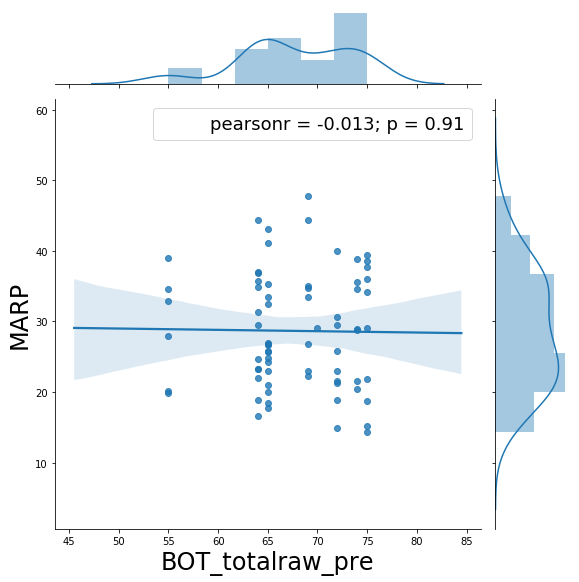

/Users/adelardalan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


<Figure size 864x576 with 0 Axes>

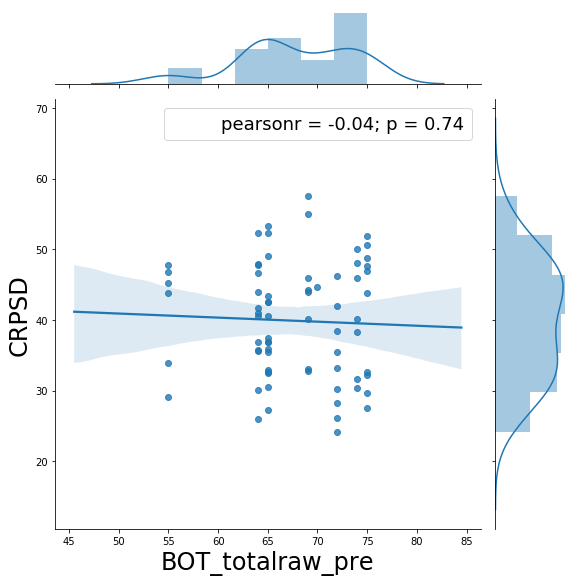

/Users/adelardalan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


<Figure size 864x576 with 0 Axes>

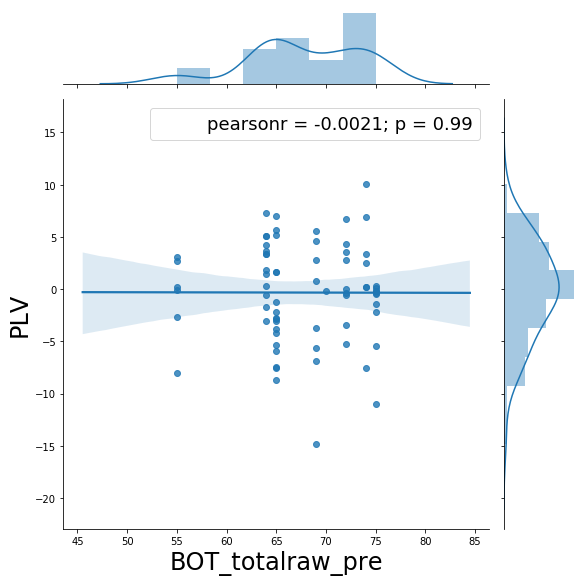

/Users/adelardalan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


<Figure size 864x576 with 0 Axes>

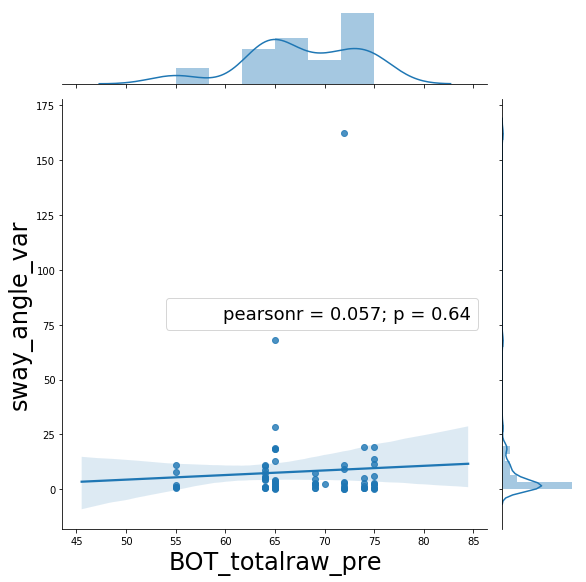

In [25]:
independent_measures = ['BOT_totalraw_pre', 'BOT_grossraw_pre', 'AGE', 'HEIGHT', 'WEIGHT']
independent_measure = 'BOT_totalraw_pre'

for cur_measure in ['MARP', 'CRPSD', 'PLV', 'sway_angle_var']:
    plt.figure(figsize=(12,8))

    g = sns.jointplot(x=independent_measure, y=cur_measure, data=sync_measures, kind='reg', height=8) #, hue="marker_color", col="marker_color", fit_reg=True)
    g.annotate(stats.pearsonr, fontsize=18)
    g.set_axis_labels(independent_measure, cur_measure, fontsize=24)
#     g.tick_params(labelsize=18)

    plt.show()